<a href="https://colab.research.google.com/github/JimHok/Software-Design-for-AI/blob/SThinnaphat-patch-7/plate_detect_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import cv2

# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('/content/drive/MyDrive/1.png')
    
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 200))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[20:25,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/3,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

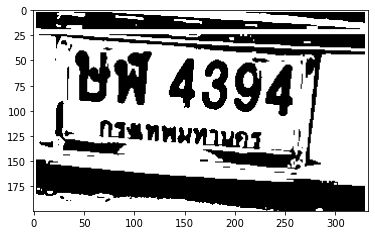

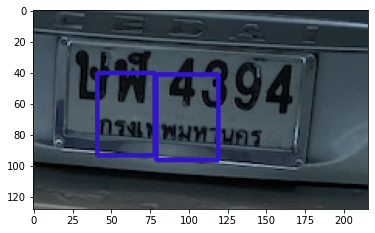

In [ ]:
img = cv2.imread('/content/drive/MyDrive/1.png')
char = segment_characters(img)

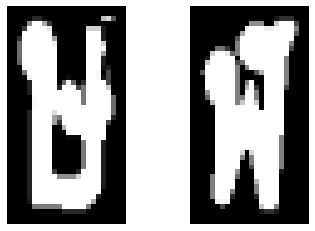

In [ ]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

### Model for characters

In [ ]:
import tensorflow as tf
# tf.enable_eager_execution()
tf.executing_eagerly()

True

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size=(99, 99)

datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

train_generator = datagen.flow_from_directory(
        '/content/drive/MyDrive/KVIS TOCR Dataset/',
        subset='training',
        target_size=image_size,
        batch_size=32,
        class_mode='categorical')
validation_generator = datagen.flow_from_directory(
        '/content/drive/MyDrive/KVIS TOCR Dataset',
        subset='validation',
        target_size=image_size,
        batch_size=32,
        class_mode='categorical')

Found 830 images belonging to 44 classes.
Found 194 images belonging to 44 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers
import tensorflow_hub as hub

In [ ]:
model = Sequential()
#CNN
# input -> conv -> maxpool -> conv -> maxpool ......->flattened vector-> 
#.                        hidden layer -> hidden layer -> softmax layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(99,99,3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))

model.add(Dense(44,activation ="softmax"))


model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 97, 97, 32)        896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 22, 22, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 11, 11, 128)     

In [ ]:
batch_size = 32
# callbacks = [tensorboard_callback, stop_training_callback()]
# callbacks = [stop_training_callback()]
model.fit(train_generator,
          steps_per_epoch = train_generator.samples // batch_size,
          validation_data = validation_generator,
          validation_steps = validation_generator.samples // batch_size,
          epochs = 100, verbose=1,
          )

Epoch 1/100
25/25 [==============================] - 92s 201ms/step - loss: 3.7901 - accuracy: 0.0263 - val_loss: 3.7869 - val_accuracy: 0.0260
Epoch 2/100
25/25 [==============================] - 5s 196ms/step - loss: 3.7860 - accuracy: 0.0251 - val_loss: 3.7840 - val_accuracy: 0.0260
Epoch 3/100
25/25 [==============================] - 4s 174ms/step - loss: 3.7843 - accuracy: 0.0238 - val_loss: 3.7824 - val_accuracy: 0.0260
Epoch 4/100
25/25 [==============================] - 5s 211ms/step - loss: 3.7825 - accuracy: 0.0251 - val_loss: 3.7820 - val_accuracy: 0.0208
Epoch 5/100
25/25 [==============================] - 4s 171ms/step - loss: 3.7825 - accuracy: 0.0226 - val_loss: 3.7807 - val_accuracy: 0.0208
Epoch 6/100
25/25 [==============================] - 5s 187ms/step - loss: 3.7821 - accuracy: 0.0226 - val_loss: 3.7802 - val_accuracy: 0.0208
Epoch 7/100
25/25 [==============================] - 6s 234ms/step - loss: 3.7810 - accuracy: 0.0238 - val_loss: 3.7804 - val_accuracy: 0.020

KeyboardInterrupt: ignored

In [ ]:
# model = Sequential()
# model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
# # model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
# # model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(44, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

In [ ]:
# ACCURACY_THRESHOLD = 0.992
# class stop_training_callback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('accuracy') > ACCURACY_THRESHOLD):
# #     if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
#       self.model.stop_training = True

In [ ]:
# import datetime
# # !rm -rf logs
# log_dir="../AI-based-indian-license-plate-detection-master/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# batch_size = 32
# # callbacks = [tensorboard_callback, stop_training_callback()]
# # callbacks = [stop_training_callback()]
# model.fit(train_generator,
#           steps_per_epoch = train_generator.samples // batch_size,
#           validation_data = validation_generator,
#           validation_steps = validation_generator.samples // batch_size,
#           epochs = 10, verbose=1,
#           )

In [ ]:

# %load_ext tensorboard
# %tensorboard --logdir logs/fit

In [ ]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c
    

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict(img)[0] #predicting the class
        for num in range(len(y_)):
            if y_[num] == 1:
                y_num = num
#         print(img)
#         print(y_)
#         print(dic)
        
        character = dic[y_num] 
#         print(character)
        output.append(character) #storing the result in a list
        
        
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())


In [ ]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()